### Декомпозиция

#### 1. Откроем файл с данными и изучим общую информацию

#### 2. Предобработка данных
- ##### Удалим явные дубликаты
- ##### Заменим названия столбцов
- ##### Создадим столбцы с датой

#### 3. Исследовательский анализ данных
- ##### Посмотрим сколько всего событий в логе
- ##### Посмотрим сколько всего пользователей в логе
- ##### Посмотрим сколько в среднем событий приходится на пользователя
- ##### Посмотрим на распределение событий по дате
- ##### Задаем рамки исследуемого диапазона

#### 4. Изучим воронку событий
- ##### Посмотрим, какие события есть в логах и как часто они встречаются
- ##### Посчитаем, сколько пользователей совершали каждое из этих событий
- ##### Посчитаем долю пользователей, которые хоть раз совершали событие
- ##### По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем)

#### 5. Изучим результаты эксперимента
- ##### Посмотрим сколько пользователей в каждой экспериментальной группе
- ##### Проверим, находят ли статистические критерии разницу между выборками 246 и 247
- ##### Посчитаем число пользователей, совершивших самое популярное событие в каждой из контрольных групп
- ##### Посчитаем долю пользователей, совершивших это событие
- ##### Проверим, будет ли отличие между группами статистически достоверным
- ##### Проведем анализ для остальных событий с контрольными группами
- ##### Сравним результаты группы 248 с каждой из контрольных групп в отдельности по каждому событию

#### 6. Общий вывод
---

#### 1. Откроем файл с данными и изучим общую информацию

In [29]:
# Импортируем библиотеки
import pandas as pd
import numpy as np
import scipy.stats as stats
import math as mth
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "png"
from plotly import graph_objects as go
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
from scipy import stats as st

In [30]:
# Задаем параметры просмотра
try:
    df = pd.read_csv('/datasets/logs_exp.csv', sep='\t') 
except:
    df = pd.read_csv('practicum_datasets/logs_exp.csv', sep='\t')

# Задаем настройки отображения
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [31]:
# Выведем первые пять строк датасета
df.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [32]:
# Выведем общую информацию
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [33]:
# Посмотрим кол-во пропусков
df.isna().sum()

EventName         0
DeviceIDHash      0
EventTimestamp    0
ExpId             0
dtype: int64

In [34]:
# Найдем явные дуюликаты
print('Ко-во дубликатов:', df.duplicated().sum())

Ко-во дубликатов: 413


In [35]:
# Посмотрим неявные дубликаты в столбце event_name
df['EventName'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

In [36]:
# Посмотрим неявные дубликаты в столбце exp_id
df['ExpId'].unique()

array([246, 248, 247])

**Вывод:** 
- Найдено 413 явных дубликата
- Скрытых дубликатов в столбцах EventName и ExpId не обнаружено
- Столбец EventTimestamp имеет тип int64 
- Названия столбцов датасета не приведены к змеиному регистру
- Пропусков не обнаружено

#### 2. Предобработка данных

##### Удалим явные дубликаты

In [37]:
# Удаляем дубликаты
df = df.drop_duplicates()

# Выводим информацию
print('Ко-во дубликатов:', df.duplicated().sum())

Ко-во дубликатов: 0


##### Заменим названия столбцов

In [38]:
# Переименуем стобцы
df.columns = df.columns.str.lower()
df = df.rename(columns={'eventname': 'event_name', 'deviceidhash': 'user_id', 
                        'eventtimestamp': 'event_timestamp', 'expid': 'group_number'})

In [39]:
# Заменим названия в столбце event_name
df['event_name'] = df['event_name'].replace('MainScreenAppear', 'main_screen_appear', regex = True)
df['event_name'] = df['event_name'].replace('PaymentScreenSuccessful', 'payment_screen_successful', regex = True)
df['event_name'] = df['event_name'].replace('CartScreenAppear', 'cart_screen_appear', regex = True)
df['event_name'] = df['event_name'].replace('OffersScreenAppear', 'offers_screen_appear', regex = True)
df['event_name'] = df['event_name'].replace('Tutorial', 'tutorial', regex = True)

##### Создадим столбцы с датой

In [40]:
# Создаем столбец с датой
df['date_time'] = pd.to_datetime(df['event_timestamp'], unit = 's')
df['date'] = df['date_time'].dt.date

# Приводим date к нужному типу данных
df = df.astype({'date': 'datetime64[ns]'})

**Вывод:**
- Дубликаты удалены 
- Названия столбцов приведены к змеиному регистру
- Созданы два столбца date и date_time с датой и датой с временем соответственно

#### 3. Исследовательский анализ данных

In [41]:
# Выведем первые 5 строк
display(df.head())

,event_name,user_id,event_timestamp,group_number,date_time,date
0,main_screen_appear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,main_screen_appear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,payment_screen_successful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,cart_screen_appear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,payment_screen_successful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


##### Посмотрим сколько всего событий в логе

In [42]:
# Выводим кол-во событий
print('Событий в логе:', df['event_name'].count())

Событий в логе: 243713


In [43]:
# Выводим кол-во событий в разрезе по названию
display(df.value_counts('event_name'))

event_name
main_screen_appear           119101
offers_screen_appear          46808
cart_screen_appear            42668
payment_screen_successful     34118
tutorial                       1018
dtype: int64

##### Посмотрим сколько всего пользователей в логе

In [44]:
# Выводим кол-во пользователей
print('Пользователей в логе:', df['user_id'].nunique())

Пользователей в логе: 7551


##### Посмотрим сколько в среднем событий приходится на пользователя

In [45]:
# Выводим кол-во событий на пользователя
print('В среднем на одного пользователя приходится:', 
      round(df['event_name'].count()/df['user_id'].nunique(), 1), 'события')

В среднем на одного пользователя приходится: 32.3 события


##### Посмотрим на распределение событий по дате

In [46]:
# Выводим минимальную дату
print('Минимальная дата:', df['date_time'].min())

# Выводим максимальную дату
print('Максимальная дата:', df['date_time'].max())

Минимальная дата: 2019-07-25 04:43:36
Максимальная дата: 2019-08-07 21:15:17


Рамки временного диапазона датасета составляют: 2019-07-25 - 2019-08-07

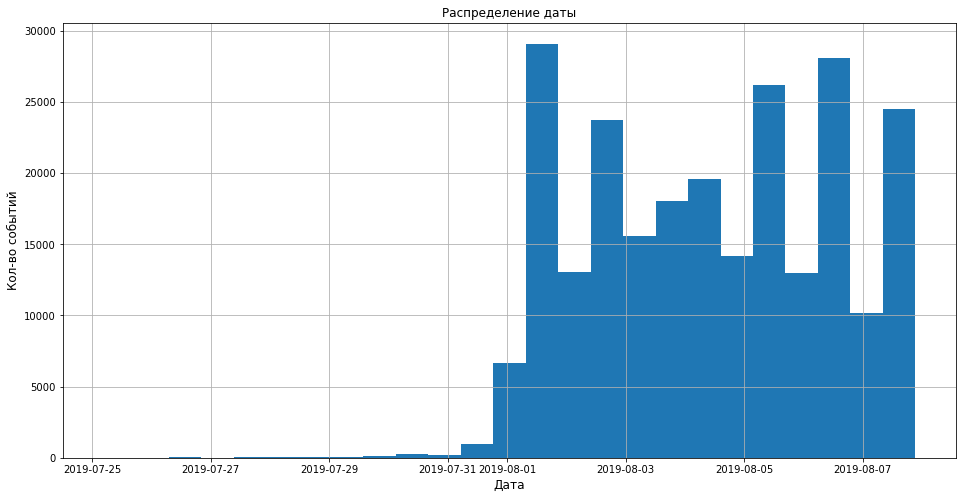

In [47]:
# Построим график распределения даты
df['date_time'].hist(figsize=(16, 8), bins=25)
plt.title('Распределение даты')
plt.xlabel('Дата', fontsize = 12)
plt.ylabel('Кол-во событий', fontsize = 12)
plt.show()

In [48]:
# Выведем кол-во событий в разрезе по дате
display(df.groupby('date')['event_name'].count())

date
2019-07-25        9
2019-07-26       31
2019-07-27       55
2019-07-28      105
2019-07-29      184
2019-07-30      412
2019-07-31     2030
2019-08-01    36141
2019-08-02    35554
2019-08-03    33282
2019-08-04    32968
2019-08-05    36058
2019-08-06    35788
2019-08-07    31096
Name: event_name, dtype: int64

Мы видим неравномерное распределение данных. Начиная с 01.08.2019 данные становятся пригодными для анализа. Все события до этой даты мы отбрасываем, т.к. они могут исказить результат. 

##### Задаем рамки исследуемого диапазона

In [49]:
# Создадим датафрейм data с заданным интервалом
data = df.loc[(df['date'] >= '2019-08-01')]

In [50]:
# Выводим минимальную дату
print('Минимальная дата:', data['date_time'].min())

# Выводим максимальную дату
print('Максимальная дата:', data['date_time'].max())

Минимальная дата: 2019-08-01 00:07:28
Максимальная дата: 2019-08-07 21:15:17


Мы распологаем данными с 01.08.2019 по 07.08.2019 (7 дней).

In [51]:
# Проверим много ли событий и пользователей мы потеряли, отбросив старые данные
# Кол-во событий
print('Событий отсечено:', df['event_name'].count() - data['event_name'].count(), 'В процентном соотношении:',
     round((df['event_name'].count() - data['event_name'].count()) / df['event_name'].count() * 100, 2), '%')

# Кол-во пользователей
print('Пользователей отсечено:', df['user_id'].nunique() - data['user_id'].nunique(), 'В процентном соотношении:',
     round((df['user_id'].nunique() - data['user_id'].nunique()) / df['user_id'].nunique() * 100, 2), '%')

Событий отсечено: 2826 В процентном соотношении: 1.16 %
Пользователей отсечено: 17 В процентном соотношении: 0.23 %


In [52]:
# Проверим, что у вас есть пользователи из всех трёх экспериментальных групп
display(data['group_number'].unique())

array([246, 247, 248])

**Вывод:** 

Проанализировав датасет мы приняли решения отсечь данные для достоверного анализа. Мы отсекли 1.16 % событий и 0.23 % пользователей, что является допустимой погрешностью и не повлияет на общие результаты исследования. Исследуемый промежуток: с 01.08.2019 по 07.08.2019 (7 дней). Пользователи из всех трех экспериментальных групп присутствуют в обновленном датасете.

#### 4. Изучим воронку событий

##### Посмотрим, какие события есть в логах и как часто они встречаются

In [54]:
# Создаем таблицу
event_count = data.groupby('event_name').agg({'event_name': 'count'})
event_count.columns = ['event_count']

# Выводим данные
display(event_count.sort_values(by='event_count', ascending=False))

,event_count
event_name,
main_screen_appear,117328
offers_screen_appear,46333
cart_screen_appear,42303
payment_screen_successful,33918
tutorial,1005


##### Посчитаем, сколько пользователей совершали каждое из этих событий

In [55]:
# Создаем таблицу
user_count = data.groupby('event_name').agg({'user_id': 'nunique'}).sort_values(by='user_id', ascending=False)
user_count.columns = ['user_count']

# Выводим данные
display(user_count)

,user_count
event_name,
main_screen_appear,7419
offers_screen_appear,4593
cart_screen_appear,3734
payment_screen_successful,3539
tutorial,840


##### Посчитаем долю пользователей, которые хоть раз совершали событие

In [56]:
# Соединяем таблицы
user_activity = event_count.merge(user_count, on='event_name').sort_values(by='user_count', ascending=False)
user_activity['conversion'] = round(user_activity['user_count'] / data['user_id'].nunique() * 100, 2)

# Уберем tutorial из воронки
user_activity = user_activity.query('event_name != "tutorial"').reset_index()

# Выводим данные
display(user_activity)

,event_name,event_count,user_count,conversion
0,main_screen_appear,117328,7419,98.47
1,offers_screen_appear,46333,4593,60.96
2,cart_screen_appear,42303,3734,49.56
3,payment_screen_successful,33918,3539,46.97


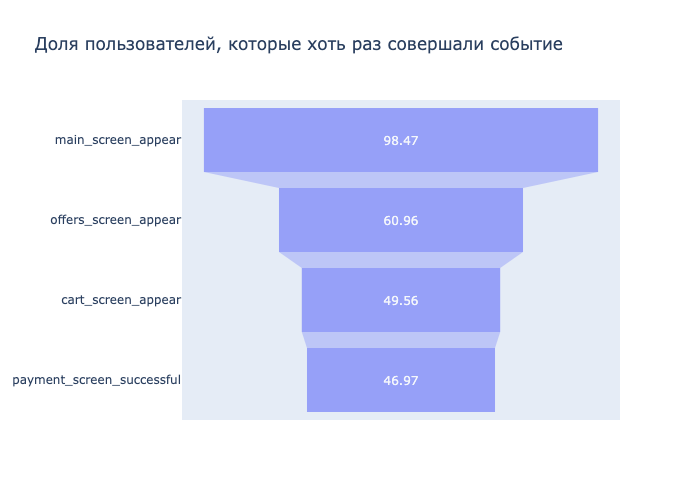

In [57]:
# Строим воронку
fig = go.Figure(go.Funnel(y = user_activity['event_name'],
                          x = user_activity['conversion'],
                          opacity = 0.6))
fig.update_layout(title_text='Доля пользователей, которые хоть раз совершали событие')
fig.show()

Из расчетов можно предположить последовательность действий пользователей.
- переход на главную страницу (98.47%)
- переход на страницу товаров (60.96%)
- переход в корзину (49.56%)
- подтверждение оплаты (46.97%)


##### По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем)

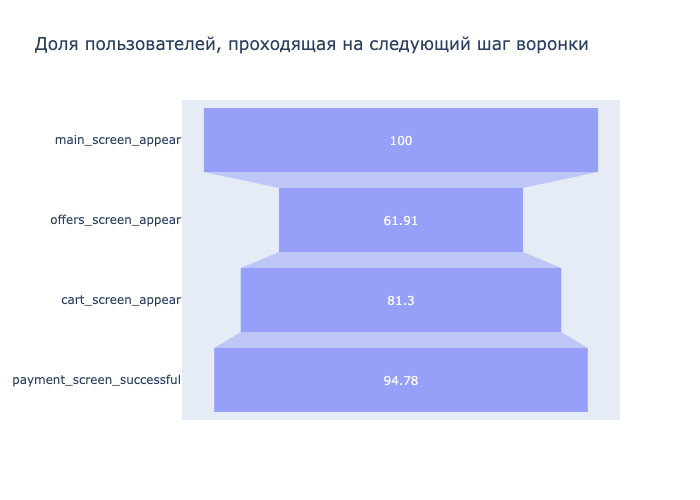

In [58]:
# Добавляем столбец с конверсией
user_activity['conversion_by_step'] = round((user_activity['user_count'].pct_change().fillna(0)+1) * 100, 2)

# Строим воронку
fig = go.Figure(go.Funnel(y = user_activity['event_name'],
                          x = user_activity['conversion_by_step'],
                          opacity = 0.6))
fig.update_layout(title_text='Доля пользователей, проходящая на следующий шаг воронки')
fig.show()

**Вывод:**
Последовательность действий выглядит следующим образом:
- переход на главную страницу (98.47%)
- переход на страницу товаров (60.96%)
- переход в корзину (49.56%)
- подтверждение оплаты (46.97%)

От первого шага до оплаты доходит 46.97% покупателей. 

*Самый слабые шаг по конверсии - offers_screen_appear (61.91%).* 

Если tutorial для нас не так важен, т.к. покупатель уже совершил покупку, то на offers_screen_appear стоит обратить внимание, т.к. при переходе с главной страницы на страницу с предложением товара "отваливается" большой процент людей, а именно - 38%. Стоит поработать с конверсией именно на этом шаге.

#### 5. Изучим результаты эксперимента

##### Посмотрим сколько пользователей в каждой экспериментальной группе

In [59]:
# Группируем таблицу
group = data.groupby('group_number').agg({'user_id': 'nunique'})

# Выводим данные
display(group)

,user_id
group_number,
246,2484
247,2513
248,2537


- В группе 246 - 2484 пользователя
- В группе 247 - 2513 пользователя
- В группе 248 - 2537 пользователя

In [60]:
# Найдем пересекающихся пользователей
group_crossed = group.reset_index()
display(group_crossed)

,group_number,user_id
0,246,2484
1,247,2513
2,248,2537


In [61]:
# Задаем таблицы
group_246 = group_crossed.query('group_number == 246')
group_247 = group_crossed.query('group_number == 247')
group_248 = group_crossed.query('group_number == 248')

# Попарно находим уникальные id пользователей
group_aa = group_246.merge(group_247, on='user_id')['user_id'].unique()
group_ab = group_247.merge(group_248, on='user_id')['user_id'].unique()
group_bb = group_246.merge(group_248, on='user_id')['user_id'].unique()

# Выводим данные
print(f'Количество покупателей, которые попали в группы 246 и 247: {len(group_ab)}')
print(f'Количество покупателей, которые попали в группы 247 и 248: {len(group_ab)}')
print(f'Количество покупателей, которые попали в группы 246 и 248: {len(group_ab)}')

Количество покупателей, которые попали в группы 246 и 247: 0
Количество покупателей, которые попали в группы 247 и 248: 0
Количество покупателей, которые попали в группы 246 и 248: 0


Пересекающихся пользователей между группами 246, 247, 248 - не обнаружено.

##### Проверим, находят ли статистические критерии разницу между выборками 246 и 247

In [36]:
# Находим разницу пользователей
print('Разница пользователей между выборками составляет', \
      round(100 - (group.loc[246, 'user_id'] / group.loc[247, 'user_id'] * 100), 2), '%')

Разница пользователей между выборками составляет 1.15 %


1.15 % разницы пользователей не является критически значимой для исследования.

##### Посчитаем число пользователей, совершивших самое популярное событие в каждой из контрольных групп

Исходя из предыдущих расчетов, самое популярное событие - main_screen_appear с конверсией 98.47% и кол-вом переходов 117 328 раз

In [62]:
# Строим таблицу с кол-вом пользователей по контрольным группам
event = data.pivot_table(index='event_name', 
                         columns='group_number', 
                         values='user_id', 
                         aggfunc='nunique').sort_values(by=246, ascending=False)

# Выводим данные
display(event)

group_number,246,247,248
event_name,,,
main_screen_appear,2450,2476,2493
offers_screen_appear,1542,1520,1531
cart_screen_appear,1266,1238,1230
payment_screen_successful,1200,1158,1181
tutorial,278,283,279


- Количество уникальных пользователей в группе 246 = 2450
- Количество уникальных пользователей в группе 247 = 2476

##### Посчитаем долю пользователей, совершивших это событие

In [64]:
# Создаем столбцы с долей пользователей по группам 246 и 247
event['user_percent_246'] = round((event[246] / data['user_id'].nunique() * 100), 2)
event['user_percent_247'] = round((event[247] / data['user_id'].nunique() * 100), 2)

# Выводим данные
display(event)

group_number,246,247,248,user_percent_246,user_percent_247
event_name,,,,,
main_screen_appear,2450,2476,2493,32.52,32.86
offers_screen_appear,1542,1520,1531,20.47,20.18
cart_screen_appear,1266,1238,1230,16.80,16.43
payment_screen_successful,1200,1158,1181,15.93,15.37
tutorial,278,283,279,3.69,3.76


- Доля уникальных пользователей в группе 246 = 32.52%
- Доля уникальных пользователей в группе 247 = 32.86%

##### Проверим, будет ли отличие между группами статистически достоверным

Проверим гипотезу о равенстве долей уникальных пользователей между группами 246 и 247.
Сформулируем гипотезы:
- H0: Доля уникальных пользователей в обеих группах равна
- H1: Количество уникальных пользователей в обеих группах имеет значимое различие

- alpha = 0.05

In [39]:
# Напишем функцию для z-теста:
def z_test(a, b , c, d):

    successes = np.array([c, d])
    trials = np.array([a, b])
    p1 = successes[0]/trials[0]
    p2 = successes[1]/trials[1]
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
    difference = p1 - p2 

    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
    distr = st.norm(0, 1)  

    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу, имеется значимое различие в группах')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, значения в группах равны') 

In [40]:
# Зададим значения alpha:
alpha = 0.05

# Проведем z-тест:
z_test(group.loc[246, 'user_id'], 
       group.loc[247, 'user_id'], 
       event.loc['main_screen_appear', 246], 
       event.loc['main_screen_appear', 247])

p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, значения в группах равны


##### Проведем анализ для остальных событий с контрольными группами

In [41]:
# Зададим значения alpha:
alpha = 0.05

# Проведем z-тест:
for c, r in event.iterrows():
    print('Столбец:', c)
    z_test(group.loc[246, 'user_id'], 
           group.loc[247, 'user_id'], 
           r[246],
           r[247])
    print()

Столбец: main_screen_appear
p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, значения в группах равны

Столбец: offers_screen_appear
p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, значения в группах равны

Столбец: cart_screen_appear
p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, значения в группах равны

Столбец: payment_screen_successful
p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, значения в группах равны

Столбец: tutorial
p-значение:  0.9376996189257114
Не получилось отвергнуть нулевую гипотезу, значения в группах равны



**Вывод:** между контрольными группами 246 и 247 нет статистической разницы. Разбитие на группы работает корректно.

##### Сравним результаты группы 248 с каждой из контрольных групп в отдельности по каждому событию

In [65]:
# Добавим столбец join_group с суммой числа пользователей из 246 и 247 группы:
event['join_group'] = event[246] + event[247]

# Выводим данные
display(event)

group_number,246,247,248,user_percent_246,user_percent_247,join_group
event_name,,,,,,
main_screen_appear,2450,2476,2493,32.52,32.86,4926
offers_screen_appear,1542,1520,1531,20.47,20.18,3062
cart_screen_appear,1266,1238,1230,16.80,16.43,2504
payment_screen_successful,1200,1158,1181,15.93,15.37,2358
tutorial,278,283,279,3.69,3.76,561


In [66]:
# Добавим строку sum с суммой пользователей из 246 и 247 группой:
group.loc['sum'] = group.loc[246, 'user_id'] + group.loc[247, 'user_id']

# Выводим данные
display(group)

,user_id
group_number,
246,2484
247,2513
248,2537
sum,4997


Сформулируем гипотезы:
- H0: Доля уникальных пользователей в обеих группах равна
- H1: Количество уникальных пользователей в обеих группах имеет значимое различие

- alpha = 0.05

Проведем тест для 246 и 248 групп:

In [44]:
# Зададим значения alpha:
alpha = 0.05

# Проведем z-тест:
for c, r in event.iterrows():
    print('Столбец:', c)
    z_test(group.loc[246, 'user_id'], 
           group.loc[248, 'user_id'], 
           r[246],
           r[248])
    print()

Столбец: main_screen_appear
p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, значения в группах равны

Столбец: offers_screen_appear
p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, значения в группах равны

Столбец: cart_screen_appear
p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, значения в группах равны

Столбец: payment_screen_successful
p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, значения в группах равны

Столбец: tutorial
p-значение:  0.8264294010087645
Не получилось отвергнуть нулевую гипотезу, значения в группах равны



Проведем тест для 247 и 248 групп:

In [45]:
# Зададим значения alpha:
alpha = 0.05

# Проведем z-тест:
for c, r in event.iterrows():
    print('Столбец:', c)
    z_test(group.loc[247, 'user_id'], 
           group.loc[248, 'user_id'], 
           r[247],
           r[248])
    print()

Столбец: main_screen_appear
p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, значения в группах равны

Столбец: offers_screen_appear
p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, значения в группах равны

Столбец: cart_screen_appear
p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, значения в группах равны

Столбец: payment_screen_successful
p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, значения в группах равны

Столбец: tutorial
p-значение:  0.765323922474501
Не получилось отвергнуть нулевую гипотезу, значения в группах равны



Проведем тест для суммы пользователей 246 + 247 и 248 групп:

In [46]:
# Зададим значения alpha:
alpha = 0.05

# Проведем z-тест:
for c, r in event.iterrows():
    print('Столбец:', c)
    z_test(group.loc['sum', 'user_id'], 
           group.loc[248, 'user_id'], 
           r['join_group'],
           r[248])
    print()

Столбец: main_screen_appear
p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, значения в группах равны

Столбец: offers_screen_appear
p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, значения в группах равны

Столбец: cart_screen_appear
p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, значения в группах равны

Столбец: payment_screen_successful
p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, значения в группах равны

Столбец: tutorial
p-значение:  0.764862472531507
Не получилось отвергнуть нулевую гипотезу, значения в группах равны



При всех возможных вариантах сравнения групп 246, 247, суммы 246 и 247 с 248 - значимого различия в группах не обнаружено. Можно предположить, что экспериментальная группа с новыми шрифтами не дает значимых результатов.

В вышеперечисленных тестах мы использовали уровень значимости alpha = 0.05. При проведении 20 проверок Мы не нашли значимых различий количества уникальных пользователей. p-value во всех тестах был больше alpha, что не позволило отвергнуть нулевую гипотезу о равенстве долей уникальных пользователей в группах. При понижении значения alpha до 0.01 суть эксперимента не поменяется, т.к. alpha = 0.05 > alpha = 0.01, следовательно полученный результат p-value будет больше alpha = 0.01. 
Чрезмерное уменьшение уровня значимости alpha может привести к увеличению вероятности ошибки второго рода, то есть вероятности принять нулевую гипотезу, когда на самом деле она не верна. Это называется ложноотрицательным решением.

Исходя из вышеперечисленного, следует остановить тест и сделать выводы по проведенным тестам.


#### 6. Общий вывод:
- Проанализировав датасет, мы выделили оптимальный промежуток для анализа данных с 01.08.2019 по 07.08.2019. Именно этот интервал обладает достаточным количеством данных для правильной интерпретации результатов. 

- Последовательностью прохождения воронки событий является:
  1. переход на главную страницу (98.5%)
  2. переход на страницу товаров (61%)
  3. переход в корзину (49.57%)
  4. подтверждение оплаты (47%)
  5. описание (11.2%)

- Изучив воронку событий можно отметить:
  1. 46.97% покупателей доходит до оформления заказа
  2. Наименьшую конверсию по шагам показал этап tutorial. Послу покупки, пользователям не интересно смотреть дополнительную информацию.
  3. Самым проблемным моментом оказался этап перехода на страницу с товаром.
  
- При проведении А/А тестов групп 246 и 247 мы обнаружили разницу пользователей между выборками, которая составляет 1.15 %. Доля уникальных пользователей в группах оказалась примерно равна. Проведение z-теста не выявило значимых различий уникальных пользователей в группах.

- При проведении А/А/B тестов с группой 248 мы, так же, не нашли значимых различий долей групп уникальных пользователей.
---
**Рекомендации:**
- Провести глубокий анализ перехода покупателей на страницу товаров. Выявить и устранить причины спада конверсии на данном шаге. Возможно следует сделать более удобную и интуитивно-понятную навигацию сайта.
- Так же можно увеличить конверсию пользователей, переходящих в корзину. 19% покупателей теряются на данном шаге. 
- Изменение шрифта не дает видимых результатов. Тесты подтвердили, что гипотеза дизайнеров не сработала. Возможно следует направить бюджет компании в более результативное направление, например на удержание пользователя на сайте и увеличение конверсии в покупку.
